# Let's learn how to talk like IOers (Information operation-er)
This means creating a language model based on their dialogue style.

## Here's the steps
1. Prepare required resources
2. Create datasets for training and fine-tuning (with torchtext)
3. Define a seq2seq model
4. Train on a large dataset to learn how Thai in politics domain works (4,000 Nation politics and royal news)
5. Fine-tune on small (scarce) datasets to learn their speaking styles

Note:
- Even I'm writing here as `large` dataset, it's still small for learning a language model.
- The large dataset is highly bias in many senses. Not a good idea to use it for common tasks.
- The language model isn't perfect. Unfortunately sometimes a sentence ends short and doesn't sound IO-ish.

# Install required packages

In [ ]:
!pip3 install attacut emoji

     |████████████████████████████████| 1.3MB 16.2MB/s 
     |████████████████████████████████| 51kB 9.5MB/s 
     |████████████████████████████████| 481kB 47.0MB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
     |████████████████████████████████| 276kB 52.4MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 747kB 55.3MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=74d74605c7f9aed7059cebc5caad8251e8ec790b03d2525d27e413a67015f4bc
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
  Created wheel for fire: filename=fire-0.3.1-py2.py3-none-any.whl size=111005 sha256=cd5ebf2723474ce7be279bd356e2096eb2559b4da916d348facf608db603a835
  Stored in directory: /root/.cache/pip/wheels/c1/61/df/768b03527bf006b546dce284eb4249b185669e65afc5fbb2ac
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=ba1

# Download datasets

In [ ]:
!wget https://github.com/noppayut/IO-LM/raw/main/dataset/cheerlung_joined.txt

--2020-11-14 02:39:14--  https://github.com/noppayut/IO-LM/raw/main/dataset/cheerlung_joined.txt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/noppayut/IO-LM/main/dataset/cheerlung_joined.txt [following]
--2020-11-14 02:39:14--  https://raw.githubusercontent.com/noppayut/IO-LM/main/dataset/cheerlung_joined.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2160064 (2.1M) [text/plain]
Saving to: ‘cheerlung_joined.txt’

cheerlung_joined.tx 100%[===================>]   2.06M  --.-KB/s    in 0.1s    

2020-11-14 02:39:14 (18.1 MB/s) - ‘cheerlung_joined.txt’ saved [2160064/2160064]



In [ ]:
!wget https://raw.githubusercontent.com/noppayut/IO-LM/main/dataset/awesome-salim-quotes.txt

--2020-11-14 02:39:19--  https://raw.githubusercontent.com/noppayut/IO-LM/main/dataset/awesome-salim-quotes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14110 (14K) [text/plain]
Saving to: ‘awesome-salim-quotes.txt’

awesome-salim-quote 100%[===================>]  13.78K  --.-KB/s    in 0s      

2020-11-14 02:39:19 (77.4 MB/s) - ‘awesome-salim-quotes.txt’ saved [14110/14110]



In [ ]:
!wget https://github.com/noppayut/IO-LM/raw/main/dataset/nation_joined.txt

--2020-11-14 02:39:19--  https://github.com/noppayut/IO-LM/raw/main/dataset/nation_joined.txt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/noppayut/IO-LM/main/dataset/nation_joined.txt [following]
--2020-11-14 02:39:19--  https://raw.githubusercontent.com/noppayut/IO-LM/main/dataset/nation_joined.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20315520 (19M) [text/plain]
Saving to: ‘nation_joined.txt’

nation_joined.txt   100%[===================>]  19.37M  42.0MB/s    in 0.5s    

2020-11-14 02:39:20 (42.0 MB/s) - ‘nation_joined.txt’ saved [20315520/20315520]



# Prepare data
- Define tokenizer
- Declare Field
- Load data from text files
- Create iterators

In [ ]:
import math

import torch
import torch.nn as nn

import torchtext
from torchtext.data import Field, BPTTIterator

from attacut import tokenize as attacut_tkz

In [ ]:
train_path = 'nation_joined.txt'
finetune_path = 'cheerlung_joined.txt'
finetune_asq_path = 'awesome-salim-quotes.txt'

In [ ]:
attacut_tkz("เราจะทำตามสัญญา")

['เรา', 'จะ', 'ทำ', 'ตาม', 'สัญญา']

In [ ]:
from emoji import UNICODE_EMOJI

In [ ]:
def tokenize(txt):
  def _process_emoji(tk):
    if tk in UNICODE_EMOJI or len(tk) == 0:
      return ''
    while tk[-1] in UNICODE_EMOJI:
      tk = tk[:-1]
      if len(tk) == 0:
        return ''
    return tk

  tokens = attacut_tkz(txt)
  tokens_no_emoji = [_process_emoji(tk.strip()) for tk in tokens]
  tokens_no_blank = list(filter(lambda x: len(x) > 0, tokens_no_emoji))
  return tokens_no_blank

In [ ]:
TEXT = Field(sequential=True,   
             tokenize=tokenize, 
             init_token='<sos>',
             eos_token='<eos>',
             lower=True)

In [ ]:
from torchtext.datasets import LanguageModelingDataset

In [ ]:
%%time
# This cell may take ~10 minutes to run.
train_dataset = LanguageModelingDataset(train_path, TEXT)
finetune_dataset = LanguageModelingDataset(finetune_path, TEXT)
finetune_asq_dataset = LanguageModelingDataset(finetune_asq_path, TEXT)

CPU times: user 9min 1s, sys: 14 s, total: 9min 15s
Wall time: 9min 15s


In [ ]:
for ee in train_dataset.examples:
  print(ee.text[:20])
  break

['ทนาย', 'เตรียม', 'ยื่น', 'อุทธรณ์', 'คำ', 'สั่ง', 'ไม่', 'ให้', 'ประกัน', 'อานนท์', '<eos>', 'ทนาย', 'เตรียม', 'ยื่น', 'อุทธรณ์', 'คำ', 'สั่ง', 'ไม่', 'ให้', 'ประกัน']


In [ ]:
TEXT.build_vocab(train_dataset, finetune_dataset, finetune_asq_dataset, min_freq=3)

In [ ]:
BATCH_SIZE = 200
MAX_SEQ_LEN = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_iter = BPTTIterator(train_dataset, BATCH_SIZE, MAX_SEQ_LEN, shuffle=True, device=device)

cuda


In [ ]:
finetune_iter = BPTTIterator(finetune_dataset, BATCH_SIZE, MAX_SEQ_LEN // 5, shuffle=True, device=device)
finetune_asq_iter = BPTTIterator(finetune_asq_dataset, BATCH_SIZE // 3, MAX_SEQ_LEN // 10, shuffle=True, device=device)

In [ ]:
TEXT.vocab.itos[:5], TEXT.vocab.itos.index('<eos>')

(['<unk>', '<pad>', '<sos>', '<eos>', 'การ'], 3)

In [ ]:
import numpy as np
itos = TEXT.vocab.itos

def index_to_sent(batch_field):
  arr = np.array(batch_field.tolist())
  results = np.apply_along_axis(lambda ls: [itos[l] if l < len(itos[4:]) else '<unk>' for l in ls], 1, arr)
  return results

In [ ]:
for i, batch in enumerate(finetune_iter):
  print("Batch:", i)
  texts = index_to_sent(batch.text.T)
  for text in texts[:4]:  
    print(text)
    print("-"*13)
  if i > 3:
    break

Batch: 0
['ขอ' 'มติ' 'แฟน' '<unk>' '<eos>' 'พิมพ์' '1' 'อยาก' 'ให้' 'เรา']
-------------
['มา' '<eos>' 'มา' 'แล้ว' 'ก็' 'ไป' '....' 'ไป' 'แล้ว' 'ก็']
-------------
['เห็น' 'ได้' 'คะ' '..!' '!' '<eos>' '<eos>' '#' '<unk>' 'แล้ว']
-------------
['เรา' 'ยืนยั' 'ขอ' 'จ่าย' 'เงิน' 'แต่' 'เจ้าข' 'ร้าน' 'ไม่' 'รับ']
-------------
Batch: 1
['ดำเนิน' 'คดี' 'กับ' 'คน' 'กลุ่ม' 'นี้' 'คะ' '\u200d' '️' '<eos>']
-------------
['มา' '<eos>' 'แต่' 'ถึง' 'คุณ' 'จะ' 'คุกคาม' 'เรา' 'แค่' 'ไหน']
-------------
['นะ' 'คะ' '17' '.' '57' 'น.' 'ยอด' 'เกิน' '10' ',']
-------------
['แค่' 'เขียน' 'ชื่อ' 'ไว้' 'ขอ' 'เป็น' 'คราว' 'หน้า' 'และ' 'ใน']
-------------
Batch: 2
['หาก' 'มติ' 'ท่วมท้น' 'จันทร์' 'ที่' '2' 'พฤศจิกายน' 'เวลา' '11' '.']
-------------
['<eos>' 'ก็' 'เปลี่ยนแป' 'อุดมการณ์' '<eos>' 'จุดยืน' 'ของ' 'องค์กร'
 'สื่อสาร' 'มวล']
-------------
['000' 'บาท' 'แล้ว' '<eos>' 'อยาก' 'ตรวจสอบ' 'ก็' 'มา' 'หลักฐาน' 'มี']
-------------
['ร้าน' 'ก็' 'มี' '.' '.' 'พี่' 'ๆ' 'น้อง' 'ๆ' 'ที่']
-------------
Batch: 3


In [ ]:
batch.text.T.shape

torch.Size([200, 10])

# Modeling

Create a simple seq2seq language model

Encoder
- Multihead attention x 3

Decoder
- Linear layer

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
from torch.nn import Transformer
from torch.nn import TransformerEncoder, TransformerEncoderLayer, Transformer

In [ ]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer, Transformer

class TransformerSmall(nn.Module):
    def __init__(self, n_tokens, d_model, n_heads, n_hid, n_layers, dropout=0.2):
        super(TransformerSmall, self).__init__()
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, n_heads, n_hid, dropout)
        self.encoder = TransformerEncoder(encoder_layers, n_layers)
        self.embedding = nn.Embedding(n_tokens, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, n_tokens)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src):
        device = src.device
        
        # print(src.shape)
        seq_len = src.size(0)
        mask = self._generate_square_subsequent_mask(seq_len).to(device)
        
        src = self.embedding(src) * (self.d_model ** 0.5)
        
        src = self.pos_encoder(src)
        output = self.encoder(src, mask)
        output = self.decoder(output)
        return output

In [ ]:
n_tokens = len(TEXT.vocab.itos) # the size of vocabulary
d_model = 256 # embedding dimension
n_hid = 256 # the dimension of the feedforward network model in nn.TransformerEncoder
n_layers = 3 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
n_heads = 4 # the number of heads in the multiheadattention models
dropout = 0.1 # the dropout value
print("n_vocabs", n_tokens)
model = TransformerSmall(n_tokens, d_model, n_heads, n_hid, n_layers).to(device)

n_vocabs 12147


# Define functions for training

In [ ]:
import time
def train(model, source_iter):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    ntokens = len(TEXT.vocab.stoi)
    for i, batch in enumerate(source_iter):
        # data = batch.text
        src = batch.text
        tgt = batch.target
        optimizer.zero_grad()
        output = model(src)
        # print(output.size(), tgt.size())
        loss = criterion(output.view(-1, n_tokens), tgt.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
    # print(src.shape, output.shape, output.view(-1, n_tokens).shape, tgt.shape)
    return total_loss

def evaluate(eval_model, source_iterator):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    with torch.no_grad():
      for i, batch in enumerate(source_iterator):
        # data = batch.text
        src = batch.text
        tgt = batch.target
        output = eval_model(src)
        output_flat = output.view(-1, n_tokens)
        # print(output_flat.shape, tgt.reshape(-1).shape)
        total_loss += criterion(output_flat, tgt.reshape(-1)).item()
    return total_loss

In [ ]:
sos_idx = TEXT.vocab.stoi['<sos>']
eos_idx = TEXT.vocab.stoi['<eos>']
pad_idx = TEXT.vocab.stoi['<pad>']
unk_idx = TEXT.vocab.stoi['<unk>']

def generate(model, start_sentence, max_len=20):
  model.eval()
  tks = tokenize(start_sentence)
  start_token = tks[0]
  if not start_token in TEXT.vocab.stoi:
    print("Start token not in vocab list")
    return ""
  else:
    output = tks
    generated = TEXT.process([TEXT.preprocess(start_sentence)]).to(device)
    while len(output) < max_len and not (output[-1] in ['<eos>', '<pad>']):
      # print(output, generated, generated.shape)
      out_model = model(generated)
      out_tk = out_model.argmax(2)[-1, :].unsqueeze(1)
      # print(out_model.shape, out_tk, out_tk.shape, out_model.argmax(2), out_model.argmax(2).shape)
      generated = torch.cat((generated, out_tk),dim=0)
      next_token_idx = out_tk[0, 0]
      try:
        output.append(TEXT.vocab.itos[next_token_idx])
      except IndexError:
        print("Index out of range", next_token_idx)
        return output

    return output

      

In [ ]:
# try generating something without training
print(generate(model, "ม็อบ"))

['ม็อบ', 'ร.5', 'แฟน', 'พล.อ.ประวิตร วงษ์สุวรรณ', 'สุก', 'เเท้', 'วาสนา นาน่วม', 'อ๋อย', 'เหวง', 'นายพุฒิพงษ์ ปุณณกันต์', 'รังสิมา', 'กทม.พรรคพลังประชารัฐ', 'ศูนย์วิทยาศาสตร์', 'พล.อ.ณฐพนธ์ ศรีสวัสดิ์', 'ขนาน', 'inbox', 'พื้นบ้าน', 'สำนักงานอัยการสูง', '"น.ส.วทันยา', 'เชฟ']


In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30, gamma=0.95)

# Train on Nation politics news
Train the model to predict next word in a sequence.

For example,

Given `เรา จะ ทำ ตาม`, predict `สัญญา`.


In [ ]:
n_epochs = 400
losses = []

out_format = "Epoch {}: Loss {:.4f}, LR {:.2E}, time {}"

In [ ]:
# Train loop

for epoch in range(1, n_epochs + 1):
    epoch_start_time = time.time()
    tr_loss = train(model, train_iter)
    losses.append(tr_loss)
    epoch_end_time = time.time()
    if epoch % 20 == 0:
      val_loss = evaluate(model, train_iter)
      print(generate(model, "ม็อบ"))
      print(generate(model, "ธนาธร"))
      print(out_format.format(epoch, val_loss, scheduler.get_last_lr()[0], epoch_end_time - epoch_start_time))
      print('-' * 15)

    scheduler.step()

['ม็อบ', 'ปลดแอก', 'และ', 'กลุ่มฟื้นฟู', 'ประชาธิปไตย', 'โดย', 'ไม่', 'มี', 'การ', 'ชุมนุม', 'ที่', 'จะ', 'มี', 'การ', 'ชุมนุม', 'ใน', 'วัน', 'ที่', '19', 'กันยายน']
['ธนาธร', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']
Epoch 20: Loss 629.6185, LR 1.00E-03, time 19.749066591262817
---------------
['ม็อบ', 'ปลดแอก', 'free', 'youth', 'ได้', 'โพสต์', 'ข้อความ', 'ผ่าน', 'เฟซบุ๊ก', 'ว่า', '"', '<eos>']
['ธนาธร', 'และ', 'ปิยบุตร', 'แสงกนกกุล', 'อดีต', 'ประธาน', 'คณะ', 'ก้าวหน้า', 'กล่าว', 'ว่า', 'การ', 'ชุมนุม', 'ของ', 'กลุ่มเยาวชน', 'ปลดแอก', 'ที่', 'อนุสาวรีย์ประชาธิปไตย', 'เมื่อ', 'วัน', 'ที่']
Epoch 40: Loss 593.7111, LR 9.50E-04, time 19.68177056312561
---------------
['ม็อบ', 'ปลดแอก', 'ได้', 'โพสต์', 'ข้อความ', 'ผ่าน', 'เฟซบุ๊ก', 'ว่า', '"', '<eos>']
['ธนาธร', 'จึงรุ่งเรืองกิจ', 'ประธาน', 'คณะ', 'ก้าวหน้า', 'กล่าว', 'ว่า', 'การ', 'ชุมนุม', 'ของ', 'กลุ่มเยาวชน'

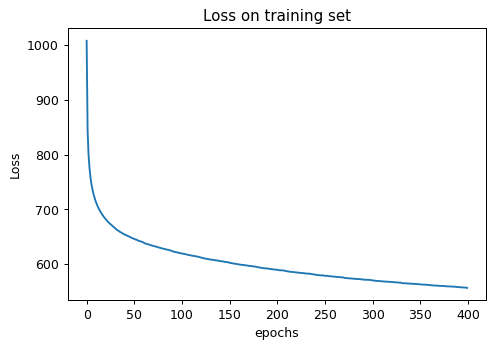

In [ ]:
import matplotlib.pyplot as plt

plt.figure(dpi=90)
plt.plot(range(len(losses)), losses)
plt.xlabel("epochs"); plt.ylabel("Loss")
_ = plt.title("Loss on training set")

# Fine-tune on Cheerlung and Awesome-salim-quotes
- Freeze the trained model's parameters
- Reset the last layer
- Fine-tune (i.e. train the last layer to adjust to a new dataset)

In [ ]:
# Freeze model parameter

for param in model.parameters():
  param.requires_grad = False

## Fine-tune on Cheerlung

In [ ]:
# Replace last layer (decoder) with a new one
model.decoder = nn.Linear(d_model, n_tokens).to(device)

In [ ]:
lr = 5e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9)

In [ ]:
n_epochs = 200
ft_losses = []

In [ ]:
for epoch in range(1, n_epochs + 1):
    epoch_start_time = time.time()
    tr_loss = train(model, finetune_iter)
    ft_losses.append(tr_loss)
    epoch_end_time = time.time()
    if epoch % 10 == 0:
      val_loss = evaluate(model, finetune_iter)
      print(generate(model, "ม็อบ"))
      print(generate(model, "ธนาธร"))
      print(out_format.format(epoch, val_loss, scheduler.get_last_lr()[0], epoch_end_time - epoch_start_time))
      print('-' * 15)

    scheduler.step()

['ม็อบ', 'สาร', 'เลว', '<eos>']
['ธนาธร', 'อ้าง', 'ชักจูง', 'โพสต์เฟซบุ๊ก', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']
Epoch 10: Loss 329.0825, LR 5.00E-03, time 2.073160409927368
---------------
['ม็อบ', 'สาร', 'เลว', '<eos>']
['ธนาธร', 'อ้าง', 'ชักจูง', 'โพสต์เฟซบุ๊ก', 'กระทำ', 'ผิด', 'ยุยง', 'ปลุกปั่น', 'ละเมิด', 'สถาบัน', 'พระมหากษัตริย์', '<eos>']
Epoch 20: Loss 320.1577, LR 5.00E-03, time 2.0244083404541016
---------------
['ม็อบ', 'สาร', 'เลว', '<eos>']
['ธนาธร', 'อ้าง', 'ชักจูง', 'โพสต์เฟซบุ๊ก', 'กระทำ', 'คืบหน้า', 'คดี', 'ทำร้าย', 'ละเมิด', 'สิทธิ', 'มนุษยชน', 'ละเมิด', 'สิทธิ', 'มนุษยชน', '<eos>']
Epoch 30: Loss 315.4570, LR 4.50E-03, time 2.128450870513916
---------------
['ม็อบ', 'สาร', 'เลว', '<eos>']
['ธนาธร', '<eos>']
Epoch 40: Loss 313.7569, LR 4.50E-03, time 2.05698299407959
---------------
['ม็อบ', 'สาร', 'เลว', '<eos>']
['ธนาธร', 'อ้าง', 'ชักจูง', 'โพสต์เฟซบุ๊ก', 'กระ

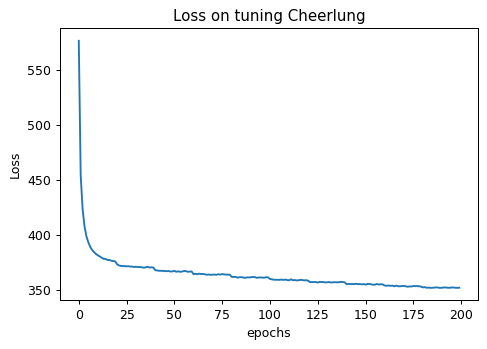

In [ ]:
plt.figure(dpi=90)
plt.plot(range(len(ft_losses)), ft_losses)
plt.xlabel("epochs"); plt.ylabel("Loss")
_ = plt.title("Loss on tuning Cheerlung")

In [ ]:
print(generate(model, "รัก"))
print(generate(model, "ลุง"))

['รัก', 'ชาติ', 'ศาสนา', 'พระมหากษัตริย์', '<eos>']
['ลุง', 'ป้อม', '<eos>']


In [ ]:
# Save model
model_save_path = "io-lm-cheerlung.pkl"

torch.save(model.state_dict(), model_save_path)

## Fine-tune on Awesome-salim-quotes

In [ ]:
model.decoder = nn.Linear(d_model, n_tokens).to(device)

lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.95)

n_epochs = 200
ft_asq_losses = []

In [ ]:
for epoch in range(1, n_epochs + 1):
    epoch_start_time = time.time()
    tr_loss = train(model, finetune_asq_iter)
    ft_asq_losses.append(tr_loss)
    epoch_end_time = time.time()
    if epoch % 10 == 0:
      val_loss = evaluate(model, finetune_asq_iter)
      print(generate(model, "ม็อบ"))
      print(generate(model, "ธนาธร"))
      print(out_format.format(epoch, val_loss, scheduler.get_last_lr()[0], epoch_end_time - epoch_start_time))
      print('-' * 15)

    scheduler.step()

['ม็อบ', 'มุ้งมิ้ง', '<eos>']
['ธนาธร', '<eos>']
Epoch 10: Loss 3.2301, LR 1.00E-02, time 0.07348036766052246
---------------
['ม็อบ', 'มุ้งมิ้ง', '<eos>']
['ธนาธร', '<eos>']
Epoch 20: Loss 2.4677, LR 1.00E-02, time 0.05993008613586426
---------------
['ม็อบ', '<eos>']
['ธนาธร', '<eos>']
Epoch 30: Loss 2.2510, LR 9.50E-03, time 0.05913853645324707
---------------
['ม็อบ', 'มุ้งมิ้ง', '<eos>']
['ธนาธร', '<eos>']
Epoch 40: Loss 2.1673, LR 9.50E-03, time 0.0595698356628418
---------------
['ม็อบ', 'มุ้งมิ้ง', '<eos>']
['ธนาธร', '<eos>']
Epoch 50: Loss 2.0793, LR 9.03E-03, time 0.05979561805725098
---------------
['ม็อบ', 'มุ้งมิ้ง', '<eos>']
['ธนาธร', '<eos>']
Epoch 60: Loss 2.0189, LR 9.03E-03, time 0.06173515319824219
---------------
['ม็อบ', 'มุ้งมิ้ง', '<eos>']
['ธนาธร', '<eos>']
Epoch 70: Loss 2.0137, LR 8.57E-03, time 0.07434201240539551
---------------
['ม็อบ', 'มุ้งมิ้ง', '<eos>']
['ธนาธร', '<eos>']
Epoch 80: Loss 1.9745, LR 8.57E-03, time 0.07861733436584473
---------------
['ม็อ

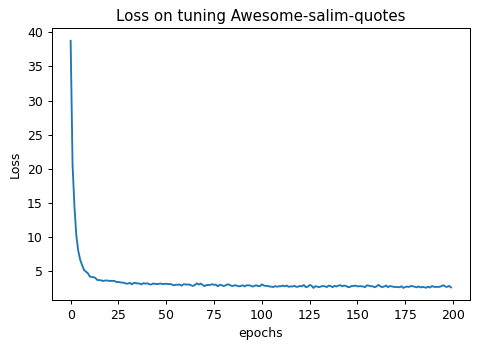

In [ ]:
plt.figure(dpi=90)
plt.plot(range(len(ft_asq_losses)), ft_asq_losses)
plt.xlabel("epochs"); plt.ylabel("Loss")
_ = plt.title("Loss on tuning Awesome-salim-quotes")

In [ ]:
print(generate(model, "รัก"))
print(generate(model, "ลุงตู่เป็น"))

['รัก', 'ปกป้อง', 'สถาบัน', '<eos>']
['ลุงตู่', 'เป็น', 'คน', 'ดี', '<eos>']


In [ ]:
print(generate(model, "ม็อบแม้ว"))
print(generate(model, "พ่อ"))

['ม็อบ', 'แม้ว', 'ซื้อ', 'ไป', 'แล้ว', '<eos>']
['พ่อ', 'มอง', 'ลง', 'มา', 'พ่อ', 'จะ', 'รู้สึก', 'ไม่', 'รู้สึก', '<unk>', 'พ่อ', 'เรา', 'ก่อน', 'จะ', 'รู้สึก', '<unk>', 'พ่อ', 'เรา', 'ก่อน', 'จะ']


In [ ]:
# Save model
model_save_path = "io-lm-asq.pkl"

torch.save(model.state_dict(), model_save_path)

# Load the saved model

In [ ]:
model_save_path = "io-lm-asq.pkl"

In [ ]:
model_loaded = TransformerSmall(n_tokens, d_model, n_heads, n_hid, n_layers).to(device)
model_loaded.load_state_dict(torch.load(model_save_path))
model_loaded.eval()

TransformerSmall(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_featu

In [ ]:
generate(model_loaded, "ท่านเหนื่อย", 50)

['ท่าน', 'เหนื่อย', 'นะ', '<eos>']